## Preprocessing and Analysis of snRNAseq Data

In this notebook I do quality control, preprocessing, and data analysis of single nuclei sequencing data (gene count matrices) generated by the Smart-seq3xpress protocol. For this I am mainly using the ScanPy module.
**Data used here is of the Spiral Ganglion Aging Atlas**

The workflow presented here contains:
- Reading the data
- Removing annotation layers and only reatining some selected annotations
- Quality control (determining outliers by counts as well as mitochondrial genes)
- Normalization using analytic Pearson residuals
- Feature selection
- Dimenstionality reduction and clustering
- UMAP embedding
- Manual cell type annotation
- Visualization of marker expression

Some quick features:
- We filter out genes that occur in <3 cells
- We filter out cells that have < 2000 genes
- We filter out cells that are outside 4 median absolute deviations of distinct gene counts or total gene counts
- We filter out mitochondrial genes (already done in this data set)

In [1]:
# Importing necessary modules for ...

# ... data processing ...
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import scipy.stats as st
import bbknn

# ... plotting ...
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc_context
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
import seaborn as sns

# ... reading and writing files
import sys, os
import json

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plotting Configuration

This cell is simply for making pretty plots.

In [2]:
# Defining custom color map for plots
with open(r".\ColorMap.csv", "r") as file:
    my_cmap_df = pd.read_csv(file, header=0)
    my_cmap = ListedColormap(my_cmap_df["HEX_Code"].to_list())

# Defining save location for plots
figures_folder = r"C:\Users\Johann\Documents\.Personal\05 Studium\02 Tübingen Neuroscience MSc\03 Lectures\04_SS_25\02_Master_Thesis\04_Figures\Assets"

# Defining folder where raw data is stored
data_folder = r"C:\Users\Johann\Documents\.Personal\05 Studium\02 Tübingen Neuroscience MSc\03 Lectures\04_SS_25\02_Master_Thesis\03_Data\01 Sequencing Data"

# Adding custom font
fonts= [r".\Arimo\Arimo-Regular.ttf",
        r".\Arimo\Arimo-SemiBold.ttf",
        r".\Arimo\Arimo-Italic.ttf",
        r".\Arimo\Arimo-SemiBoldItalic.ttf"]
for font in fonts:
    fm.fontManager.addfont(font)

# Setting parameters for ScanPy plots
sc.set_figure_params(
    dpi_save= 600,
    facecolor= "white",
    color_map= "RdPu")

scale = 1.4 #plot scale factor
fig_width = 2.35*scale

plt.rcParams["font.family"] = "Arimo"
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["axes.labelsize"] = 6*scale
plt.rcParams["axes.labelweight"] = "semibold"
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 0.7)
plt.rcParams["xtick.labelsize"] = 6*scale
plt.rcParams["ytick.labelsize"] = 6*scale
plt.rcParams["axes.titlesize"] = 8*scale
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["legend.fontsize"] = 6*scale

### Reading Data

We read the data from an .h5ad file that contains the raw count matrix with some annotations and metadata.

Information carried over is:
- plate ID (a unique barcode for each 384-well plate sequenced)
- age of animals

In [3]:
# Reading data
adatas = {"adata_3mo":  sc.read_h5ad(data_folder + r"\CBA_3mo_SGN.h5ad"),
          "adata_12mo": sc.read_h5ad(data_folder + r"\CBA_12mo_SGN.h5ad"),
          "adata_24mo": sc.read_h5ad(data_folder + r"\CBA_24mo_SGN.h5ad")}

# Getting list of genes in all data sets
features_3mo = adatas["adata_3mo"].var_names.to_list()
features_12mo = adatas["adata_12mo"].var_names.to_list()
features_24mo = adatas["adata_24mo"].var_names.to_list()
print(f"Identified {len(features_3mo)} genes in first data set.")
print(f"Identified {len(features_12mo)} genes in second data set.")
print(f"Identified {len(features_24mo)} genes in third data set.\n")

common_features = np.intersect1d(np.intersect1d(features_3mo, features_12mo), features_24mo).tolist()
print(f"Identified {len(common_features)} common genes between data sets.\n", common_features, "\n")

adatas["adata_3mo"] = adatas["adata_3mo"][:, adatas["adata_3mo"].var_names.isin(common_features)].copy()
adatas["adata_12mo"] = adatas["adata_12mo"][:, adatas["adata_12mo"].var_names.isin(common_features)].copy()
adatas["adata_24mo"] = adatas["adata_24mo"][:, adatas["adata_24mo"].var_names.isin(common_features)].copy()

print(f"Filtered dataset 1 has {adatas["adata_3mo"].n_obs} nuclei and {adatas["adata_3mo"].n_vars} genes.\n",
f"Filtered dataset 2 has {adatas["adata_12mo"].n_obs} nuclei and {adatas["adata_12mo"].n_vars} genes.\n",
f"Filtered dataset 3 has {adatas["adata_24mo"].n_obs} nuclei and {adatas["adata_24mo"].n_vars} genes.\n")

# Concatenating all age groups
adata_original = ad.concat([adatas["adata_3mo"], adatas["adata_12mo"], adatas["adata_24mo"]],
                           label= "age",
                           keys= ["3 months", "12 months", "24 months"])

# Making a clean copy ...
adata = ad.AnnData(adata_original.X.copy())

# # ... and preserving some of the metadata
adata.obs["plate"] = adata_original.obs["plate"].values.astype(str)
adata.obs["age"] = adata_original.obs["age"].values
adata.obs.set_index(adata_original.obs.index, inplace= True)
adata.var.set_index(adata_original.var.index, inplace= True)

adata

Identified 27586 genes in first data set.
Identified 24516 genes in second data set.
Identified 25406 genes in third data set.

Identified 20454 common genes between data sets.
 ['A1cf', 'A2m', 'A2ml1', 'A3galt2', 'A4galt', 'AA386476', 'AA413626', 'AA414768', 'AA465934', 'AA474408', 'AA792892', 'AA914427', 'AA986860', 'AB124611', 'AF357399', 'AI115009', 'AI182371', 'AI197445', 'AI429214', 'AI467606', 'AI480526', 'AI504432', 'AI506816', 'AI593442', 'AI597479', 'AI661453', 'AI837181', 'AI838599', 'AI839979', 'AI854703', 'AI987944', 'AK157302', 'AU019990', 'AU020206', 'AU021092', 'AU022252', 'AU022754', 'AU023762', 'AU040320', 'AU040972', 'AU041133', 'AV039307', 'AV099323', 'AV356131', 'AW011738', 'AW046200', 'AW047730', 'AW112010', 'AW146154', 'AW209491', 'AW554918', 'AY036118', 'AY074887', 'AY358078', 'AY512915', 'Aaas', 'Aacs', 'Aadat', 'Aagab', 'Aak1', 'Aamdc', 'Aamp', 'Aanat', 'Aar2', 'Aard', 'Aars', 'Aars2', 'Aarsd1', 'Aasdh', 'Aasdhppt', 'Aass', 'Aatf', 'Aatk', 'Abat', 'Abca1', 'Ab

AnnData object with n_obs × n_vars = 8617 × 20454
    obs: 'plate', 'age'

### Quality Control

We calculate quality control metrics.

In [4]:
# Define mitochondrial, ribosomal, and hemoglobin genes by name
# (they are already filtered out in this dataset ...)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.startswith(("Rpl", "Rps"))
adata.var["hb"] = adata.var_names.str.startswith("Hb")

print(f"{len(adata.var[adata.var["mt"]])} Mitochondrial genes identified:\n", adata.var_names[adata.var["mt"]].values, "\n")
print(f"{len(adata.var[adata.var["ribo"]])} Ribosomal genes identified:\n", adata.var_names[adata.var["ribo"]].values, "\n")
print(f"{len(adata.var[adata.var["hb"]])} Hemoglobin genes identified:\n", adata.var_names[adata.var["hb"]].values)

# Calculating QC metrics including the gene subsets
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt", "ribo", "hb"],
                           inplace= True,
                           log1p= True)

adata.obs

24 Mitochondrial genes identified:
 ['mt-Atp6' 'mt-Atp8' 'mt-Co1' 'mt-Co2' 'mt-Co3' 'mt-Cytb' 'mt-Nd1'
 'mt-Nd2' 'mt-Nd3' 'mt-Nd4' 'mt-Nd4l' 'mt-Nd5' 'mt-Nd6' 'mt-Ta' 'mt-Tl1'
 'mt-Tm' 'mt-Tq' 'mt-Tt' 'mt-Tc' 'mt-Th' 'mt-Ti' 'mt-Tp' 'mt-Tw' 'mt-Te'] 

245 Ribosomal genes identified:
 ['Rpl10' 'Rpl10-ps1' 'Rpl10-ps3' 'Rpl10-ps5' 'Rpl10-ps6' 'Rpl10a'
 'Rpl10a-ps1' 'Rpl10a-ps4' 'Rpl11' 'Rpl12' 'Rpl13' 'Rpl13-ps1' 'Rpl13-ps3'
 'Rpl13-ps6' 'Rpl13a' 'Rpl14' 'Rpl14-ps1' 'Rpl15' 'Rpl15-ps2' 'Rpl15-ps3'
 'Rpl15-ps5' 'Rpl15-ps6' 'Rpl17' 'Rpl17-ps10' 'Rpl17-ps3' 'Rpl17-ps4'
 'Rpl17-ps5' 'Rpl17-ps8' 'Rpl17-ps9' 'Rpl18' 'Rpl18-ps1' 'Rpl18-ps2'
 'Rpl18a' 'Rpl19' 'Rpl19-ps1' 'Rpl19-ps11' 'Rpl19-ps3' 'Rpl19-ps6'
 'Rpl19-ps7' 'Rpl21' 'Rpl21-ps10' 'Rpl21-ps12' 'Rpl21-ps15' 'Rpl22'
 'Rpl22-ps1' 'Rpl22l1' 'Rpl23' 'Rpl23a' 'Rpl23a-ps2' 'Rpl23a-ps3' 'Rpl24'
 'Rpl26' 'Rpl27' 'Rpl27-ps1' 'Rpl27-ps3' 'Rpl27a' 'Rpl27a-ps1'
 'Rpl27a-ps4' 'Rpl28' 'Rpl28-ps1' 'Rpl28-ps3' 'Rpl29' 'Rpl3' 'Rpl3-ps1'
 'Rpl3-ps2' 'Rpl3

plate        age  n_genes_by_counts  \
AACCACATCGAACGCCTCGA  11101383   3 months                666   
AACCACATCGACAACTCGAA  11101383   3 months               1502   
AACCACATCGAGGTGTCGAG  11101383   3 months               2412   
AACCACATCGATCCAAGGAA  11101383   3 months               1984   
AACCACATCGCACGGTGGTT  11101383   3 months               3459   
...                        ...        ...                ...   
TTGTTCGTTGGAAGGCACGA  11247716  24 months               2094   
TTGTTCGTTGGACTGCTAGT  11247716  24 months               1025   
TTGTTCGTTGGCACGAGCAA  11247716  24 months               4676   
TTGTTCGTTGGCAGTAACGA  11247716  24 months               1349   
TTGTTCGTTGTCCTGCTCTG  11247716  24 months               1577   

                      log1p_n_genes_by_counts  total_counts  \
AACCACATCGAACGCCTCGA                 6.502790         752.0   
AACCACATCGACAACTCGAA                 7.315218        2678.0   
AACCACATCGAGGTGTCGAG                 7.788626        4606.0   
AACCACATCGATCCAAGGAA                 7.593374        3071.0   
AACCACATCGCACGGTGGTT                 8.149024        9852.0   
...                                       ...           ...   
TTGTTCGTTGGAAGGCACGA                 7.647309        4342.0   
TTGTTCGTTGGACTGCTAGT                 6.933423        1323.0   
TTGTTCGTTGGCACGAGCAA                 8.450412       14704.0   
TTGTTCGTTGGCAGTAACGA                 7.207860        1904.0   
TTGTTCGTTGTCCTGCTCTG                 7.363914        2113.0   

                      log1p_total_counts  pct_counts_in_top_50_genes  \
AACCACATCGAACGCCTCGA            6.624065                   15.824468   
AACCACATCGACAACTCGAA            7.893199                   16.542196   
AACCACATCGAGGTGTCGAG            8.435332                   12.440295   
AACCACATCGATCCAAGGAA            8.030084                   17.746662   
AACCACATCGCACGGTGGTT            9.195531                   17.275680   
...                                  ...                         ...   
TTGTTCGTTGGAAGGCACGA            8.376321                   18.079226   
TTGTTCGTTGGACTGCTAGT            7.188413                   15.495087   
TTGTTCGTTGGCACGAGCAA            9.595943                   15.227149   
TTGTTCGTTGGCAGTAACGA            7.552237                   15.651261   
TTGTTCGTTGTCCTGCTCTG            7.656337                   13.535258   

                      pct_counts_in_top_100_genes  \
AACCACATCGAACGCCTCGA                    24.734043   
AACCACATCGACAACTCGAA                    25.018671   
AACCACATCGAGGTGTCGAG                    18.975250   
AACCACATCGATCCAAGGAA                    23.868447   
AACCACATCGCACGGTGGTT                    23.172960   
...                                           ...   
TTGTTCGTTGGAAGGCACGA                    26.070935   
TTGTTCGTTGGACTGCTAGT                    23.053666   
TTGTTCGTTGGCACGAGCAA                    21.885201   
TTGTTCGTTGGCAGTAACGA                    23.529412   
TTGTTCGTTGTCCTGCTCTG                    20.539517   

                      pct_counts_in_top_200_genes  \
AACCACATCGAACGCCTCGA                    38.031915   
AACCACATCGACAACTCGAA                    37.640030   
AACCACATCGAGGTGTCGAG                    28.310899   
AACCACATCGATCCAAGGAA                    32.790622   
AACCACATCGCACGGTGGTT                    31.465692   
...                                           ...   
TTGTTCGTTGGAAGGCACGA                    37.033625   
TTGTTCGTTGGACTGCTAGT                    37.641723   
TTGTTCGTTGGCACGAGCAA                    30.794342   
TTGTTCGTTGGCAGTAACGA                    34.401261   
TTGTTCGTTGTCCTGCTCTG                    30.004733   

                      pct_counts_in_top_500_genes  total_counts_mt  \
AACCACATCGAACGCCTCGA                    77.925532              2.0   
AACCACATCGACAACTCGAA                    61.762509              5.0   
AACCACATCGAGGTGTCGAG                    48.219713             16.0   
AACCACATCGATCCAAGGAA                    51.676978              5.0   
AACCACATCG

In [5]:
# Calculating MAD for a given QC metric
def is_outlier(adata, metric: str, nmads: int):
    '''This function calculates whether each element of a list or series is an
    outlier based on the number of median absolute deviations (MADs) passed in the
    arguments nmads. It returns a list of booleans where each element that was an outlier
    in the original list results in a TRUE in the returned list. If you use the returned
    list for indexing to EXCLUDE outliers, remember to index with the inverse (~outliers) of the outlier
    list returned by this function'''
    M = adata.obs[metric]
    outlier = ((M < np.median(M) - nmads * st.median_abs_deviation(M)) # outlier below ...
               | (np.median(M) + nmads * st.median_abs_deviation(M) < M)) # and outlier above
    return outlier

# Defining cut-off for mitochondrial percentage
max_mito_pct = 0.3

# Defining whether a nucleus is an outlier based on total counts and gene counts per cell
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 4)
                        | is_outlier(adata, "log1p_n_genes_by_counts", 4)
                        | (adata.obs["n_genes_by_counts"] < 2000) # Custom hard threshold for minimum gene number per nucleus due to Smart-seq3xpress performance
                        | (adata.obs["pct_counts_mt"] > 0.3))

# Running doublet detection and creating a doublet score for every cell
sc.pp.scrublet(adata, batch_key= "age")

print(f"Identified {len(adata.obs[adata.obs["outlier"]])} out of {len(adata.obs)} nuclei as outliers.\n",
      "Nuclei remaining of each age group: \n",
      adata[~adata.obs["outlier"]].obs["age"].value_counts())

Identified 4396 out of 8617 nuclei as outliers.
 Nuclei remaining of each age group: 
 age
3 months     2009
24 months    1143
12 months    1069
Name: count, dtype: int64


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.violinplot(
C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\3797376473.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(["Single Nuclei"])
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalC

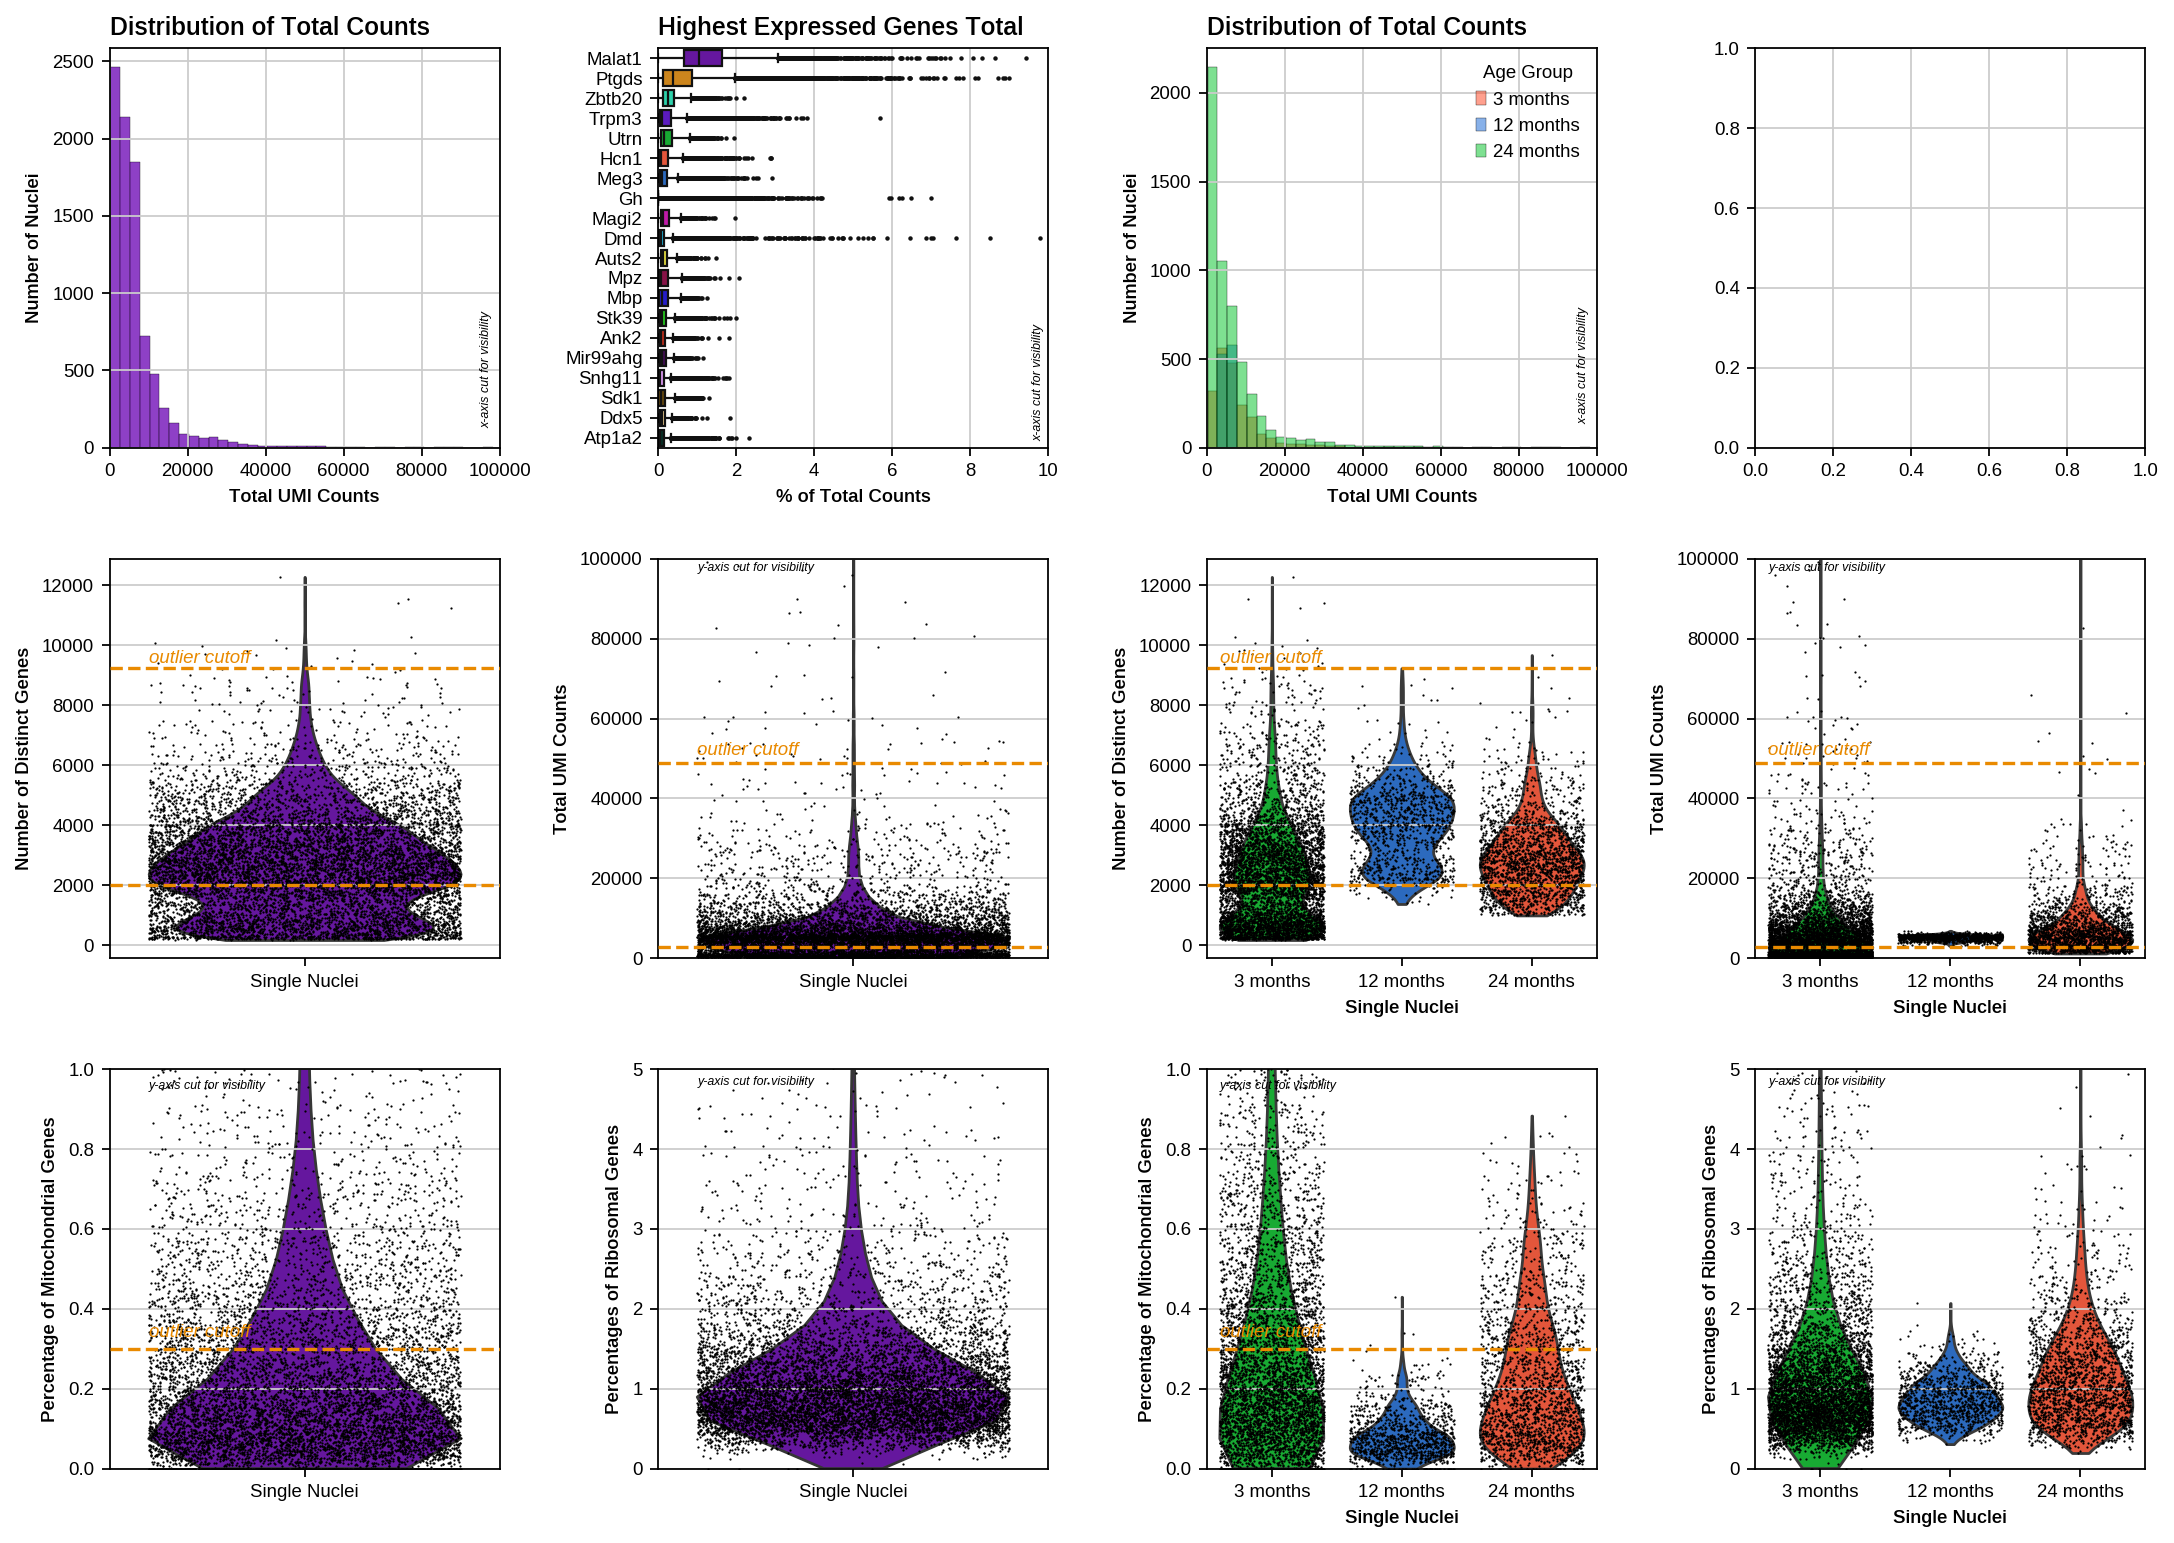

In [10]:
# Plotting Quality Control metrics
fig, axes = plt.subplots(3, 4, figsize=(fig_width*4.2, fig_width*3), layout= "constrained")

age_colors = [my_cmap.colors[4],
              my_cmap.colors[6],
              my_cmap.colors[5]]
# Gene per Nuclei (all samples)
sc.pl.violin(adata, ["n_genes_by_counts"], jitter= 0.4, ax= axes[1, 0], show= False, palette = my_cmap.colors)
axes[1, 0].set_xticklabels(["Single Nuclei"])
axes[1, 0].set_ylabel("Number of Distinct Genes")
axes[1, 0].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 0].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 0].text(-0.4, adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max()+170, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

# Genes per Nuclei (grouped by age)
sc.pl.violin(adata, ["n_genes_by_counts"], jitter= 0.4, ax= axes[1, 2], show= False, palette = age_colors, groupby= "age")
axes[1, 2].set_xlabel("Single Nuclei")
axes[1, 2].set_ylabel("Number of Distinct Genes")
axes[1, 2].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 2].axhline(adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 2].text(-0.4, adata[~adata.obs["outlier"]].obs["n_genes_by_counts"].max()+170, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

# Total Counts (all samples)
sc.pl.violin(adata, ["total_counts"], jitter= 0.4, ax= axes[1, 1], show= False, palette = my_cmap.colors)
axes[1, 1].set_xticklabels(["Single Nuclei"])
axes[1, 1].set_ylabel("Total UMI Counts")
axes[1, 1].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 1].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 1].text(-0.4, adata[~adata.obs["outlier"]].obs["total_counts"].max()+2000, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")
axes[1, 1].set_ylim(0, 100000)
axes[1, 1].text(-0.4, 97000, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

# Total Counts (grouped by age)
sc.pl.violin(adata, ["total_counts"], jitter= 0.4, ax= axes[1, 3], show= False, palette = age_colors, groupby= "age")
axes[1, 3].set_xlabel("Single Nuclei")
axes[1, 3].set_ylabel("Total UMI Counts")
axes[1, 3].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].min(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 3].axhline(adata[~adata.obs["outlier"]].obs["total_counts"].max(),
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[1, 3].text(-0.4, adata[~adata.obs["outlier"]].obs["total_counts"].max()+2000, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")
axes[1, 3].set_ylim(0, 100000)
axes[1, 3].text(-0.4, 97000, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

# Mitochondrial percentage (all samples)
sc.pl.violin(adata, ["pct_counts_mt"], jitter= 0.4, ax= axes[2, 0], show= False, palette = my_cmap.colors)
axes[2, 0].set_xticklabels(["Single Nuclei"])
axes[2, 0].set_ylabel("Percentage of Mitochondrial Genes")
axes[2, 0].set_ylim(0, 1)
axes[2, 0].text(-0.4, 0.95, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")
axes[2, 0].axhline(max_mito_pct,
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[2, 0].text(-0.4, max_mito_pct+max_mito_pct*0.1, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

# Mitochondrial percentage (grouped by age)
sc.pl.violin(adata, ["pct_counts_mt"], jitter= 0.4, ax= axes[2, 2], show= False, palette = age_colors, groupby= "age")
axes[2, 2].set_xlabel("Single Nuclei")
axes[2, 2].set_ylabel("Percentage of Mitochondrial Genes")
axes[2, 2].set_ylim(0, 1)
axes[2, 2].text(-0.4, 0.95, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")
axes[2, 2].axhline(max_mito_pct,
                   color= my_cmap.colors[1],
                   linestyle= "--",
                   zorder= 3)
axes[2, 2].text(-0.4, max_mito_pct+max_mito_pct*0.1, "outlier cutoff",
                color= my_cmap.colors[1],
                fontsize= 6*scale,
                fontstyle= "italic")

# Ribosomal percentage (all samples)
sc.pl.violin(adata, ["pct_counts_ribo"], jitter= 0.4, ax= axes[2, 1], show= False, palette = my_cmap.colors)
axes[2, 1].set_xticklabels(["Single Nuclei"])
axes[2, 1].set_ylabel("Percentages of Ribosomal Genes")
axes[2, 1].set_ylim(0, 5)
axes[2, 1].text(-0.4, 4.8, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

# Ribosomal percentage (grouped by age)
sc.pl.violin(adata, ["pct_counts_ribo"], jitter= 0.4, ax= axes[2, 3], show= False, palette = age_colors, groupby= "age")
axes[2, 3].set_xlabel("Single Nuclei")
axes[2, 3].set_ylabel("Percentages of Ribosomal Genes")
axes[2, 3].set_ylim(0, 5)
axes[2, 3].text(-0.4, 4.8, "y-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                fontstyle= "italic")

# Highest expressed genes (all samples)
sc.pl.highest_expr_genes(adata, n_top=20, ax= axes[0, 1], show= False, palette= my_cmap.colors)
axes[0, 1].set_title("Highest Expressed Genes Total")
axes[0, 1].set_xlabel(r"% of Total Counts")
axes[0, 1].set_xlim(0, 10)
axes[0, 1].text(9.6, 19, "x-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                rotation= 90,
                fontstyle= "italic")

# Total Count Distribution (all samples)
sns.histplot(adata.obs["total_counts"], bins = 100, kde= False, ax= axes[0, 0], color= my_cmap.colors[0])
axes[0, 0].set_title("Distribution of Total Counts")
axes[0, 0].set_xlabel("Total UMI Counts")
axes[0, 0].set_ylabel("Number of Nuclei")
axes[0, 0].set_xlim(0, 100000)
axes[0, 0].text(95000, 150, "x-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                rotation= 90,
                fontstyle= "italic")

# Total Counts Distribution (grouped by age)
sns.histplot(adata.obs, x= "total_counts", bins = 100, kde= False, ax= axes[0, 2], palette= age_colors, hue= "age", hue_order= ("3 months", "12 months", "24 months"))
axes[0, 2].set_title("Distribution of Total Counts")
axes[0, 2].set_xlabel("Total UMI Counts")
axes[0, 2].set_ylabel("Number of Nuclei")
axes[0, 2].legend(["3 months", "12 months", "24 months"], title= "Age Group", title_fontsize= 6*scale, frameon= False)
axes[0, 2].set_xlim(0, 100000)
axes[0, 2].text(95000, 150, "x-axis cut for visibility",
                color= "black",
                fontsize= 4*scale,
                rotation= 90,
                fontstyle= "italic")

fig.tight_layout(h_pad= 1.0*scale)
fig.savefig(figures_folder + r"\QC_metrics_SGNplates.png")
plt.show()

In [11]:
# Saving a copy of the raw counts before normalising
adata.layers["raw_counts"] = adata.X.copy()

C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\490817874.py:3: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  adata.layers["pearson_normalized_counts"] = sc.experimental.pp.normalize_pearson_residuals(adata, copy= True).X


C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\490817874.py:12: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.histplot(adata.X.sum(1), bins = 100, kde= False, ax= axes[0], palette= my_cmap.colors, legend= False)
C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\490817874.py:19: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.histplot(adata.layers["log1p_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[2], palette= my_cmap.colors, legend= False)


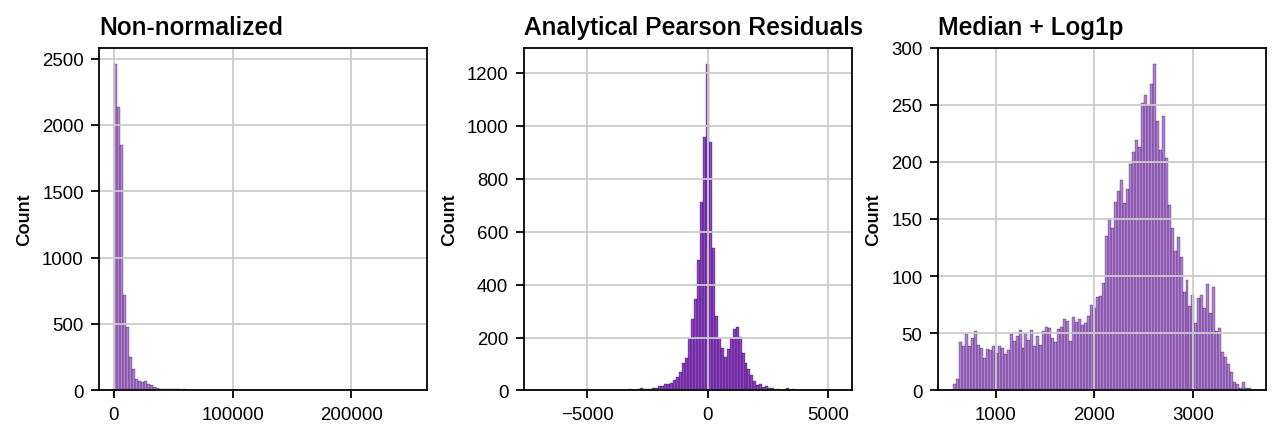

In [13]:
# Normalize the data and store the normalizations in separate layers ...
# ... by pearson residulals ...
adata.layers["pearson_normalized_counts"] = sc.experimental.pp.normalize_pearson_residuals(adata, copy= True).X

# ... and by median (with log1p transformation)
adata.layers["log1p_normalized_counts"] = sc.pp.normalize_total(adata, copy= True).X
sc.pp.log1p(adata, layer= "log1p_normalized_counts")

fig, axes = plt.subplots(1, 3, figsize=(fig_width*2.4, fig_width*0.8), layout= "constrained")

# the original layer remains raw
sns.histplot(adata.X.sum(1), bins = 100, kde= False, ax= axes[0], palette= my_cmap.colors, legend= False)
axes[0].set_title("Non-normalized")

sns.histplot(adata.layers["pearson_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[1], color= my_cmap.colors[0])
axes[1].set_title("Analytical Pearson Residuals")


sns.histplot(adata.layers["log1p_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[2], palette= my_cmap.colors, legend= False)
axes[2].set_title("Median + Log1p")

plt.show()
fig.savefig(figures_folder + r"\Normalization_Comparison_SGNplates.png")

### Feature Selection

We select the top 2000 most highly variable genes (HVGs) based on pearson normalized and median normalized data and save the annotation so separate fields.

**DO NOT RUN THE FOLLOWING CELL TWICE WITHOUT RELOADING THE DATA OR RESTARTING THE KERNEL**

In [14]:
# Feature selection based on pearson residuals (uses the raw counts by default) ...
sc.experimental.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "age")

# ... and based on log1p normalized counts
if "log1p_highly_variable" in adata.obs_names.values:
    pass
else:
    adata.var = pd.concat((adata.var,
                        sc.pp.highly_variable_genes(adata, n_top_genes= 2000,
                                                    layer= "log1p_normalized_counts",
                                                    inplace= False).rename(
                                                        columns={"highly_variable": "log1p_highly_variable",
                                                                    "means": "log1p_means",
                                                                    "dispersions": "log1p_dispersions",
                                                                    "dispersions_norm": "log1p_dispersions_norm"}).loc[:, ["log1p_highly_variable", "log1p_means", "log1p_dispersions", "log1p_dispersions_norm"]]), axis=1)

C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\2677947744.py:2: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  sc.experimental.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "age")


C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\2756258671.py:4: UserWarning: The palette list has more values (45) than needed (2), which may not be intended.
  sns.scatterplot(adata.var, x= "means", y= "residual_variances",
C:\Users\Johann\AppData\Local\Temp\ipykernel_23448\2756258671.py:17: UserWarning: The palette list has more values (45) than needed (2), which may not be intended.
  sns.scatterplot(adata.var, x= "log1p_means", y= "log1p_dispersions",


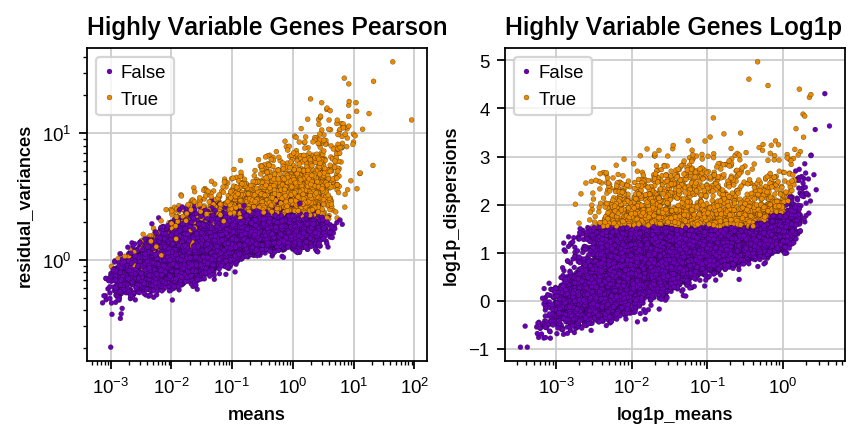

In [15]:
# Plotting highly variable gene fraction
fig, ax = plt.subplots(1,2, figsize=(fig_width*1.6, fig_width*0.8), layout= "constrained")

sns.scatterplot(adata.var, x= "means", y= "residual_variances",
                hue= "highly_variable", 
                palette= my_cmap.colors,
                ax= ax[0], 
                s= 5,
                edgecolor= "black",
                linewidth= 0.1,
                zorder= 2)
ax[0].set_title("Highly Variable Genes Pearson")
ax[0].legend()
ax[0].set_xscale("log")
ax[0].set_yscale("log")

sns.scatterplot(adata.var, x= "log1p_means", y= "log1p_dispersions",
                hue= "log1p_highly_variable",
                palette= my_cmap.colors,
                ax= ax[1],
                s= 5,
                edgecolor= "black",
                linewidth= 0.1,
                zorder= 2)
ax[1].set_title("Highly Variable Genes Log1p")
ax[1].set_xscale("log")
ax[1].legend()

fig.savefig(figures_folder + r"\Highly_Variable_SGNplates.png")

### Dimensionality Reduction

We compute principal components on the pearson normalized count matrix.

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\experimental\pp\_normalization.py:242: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  normalize_pearson_residuals(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_tools\scatterplots.py:468: UserWarning: Adding colorbar to a different Figure <Figure size 921.2x421.12 with 7 Axes> than <Figure size 320x320 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(


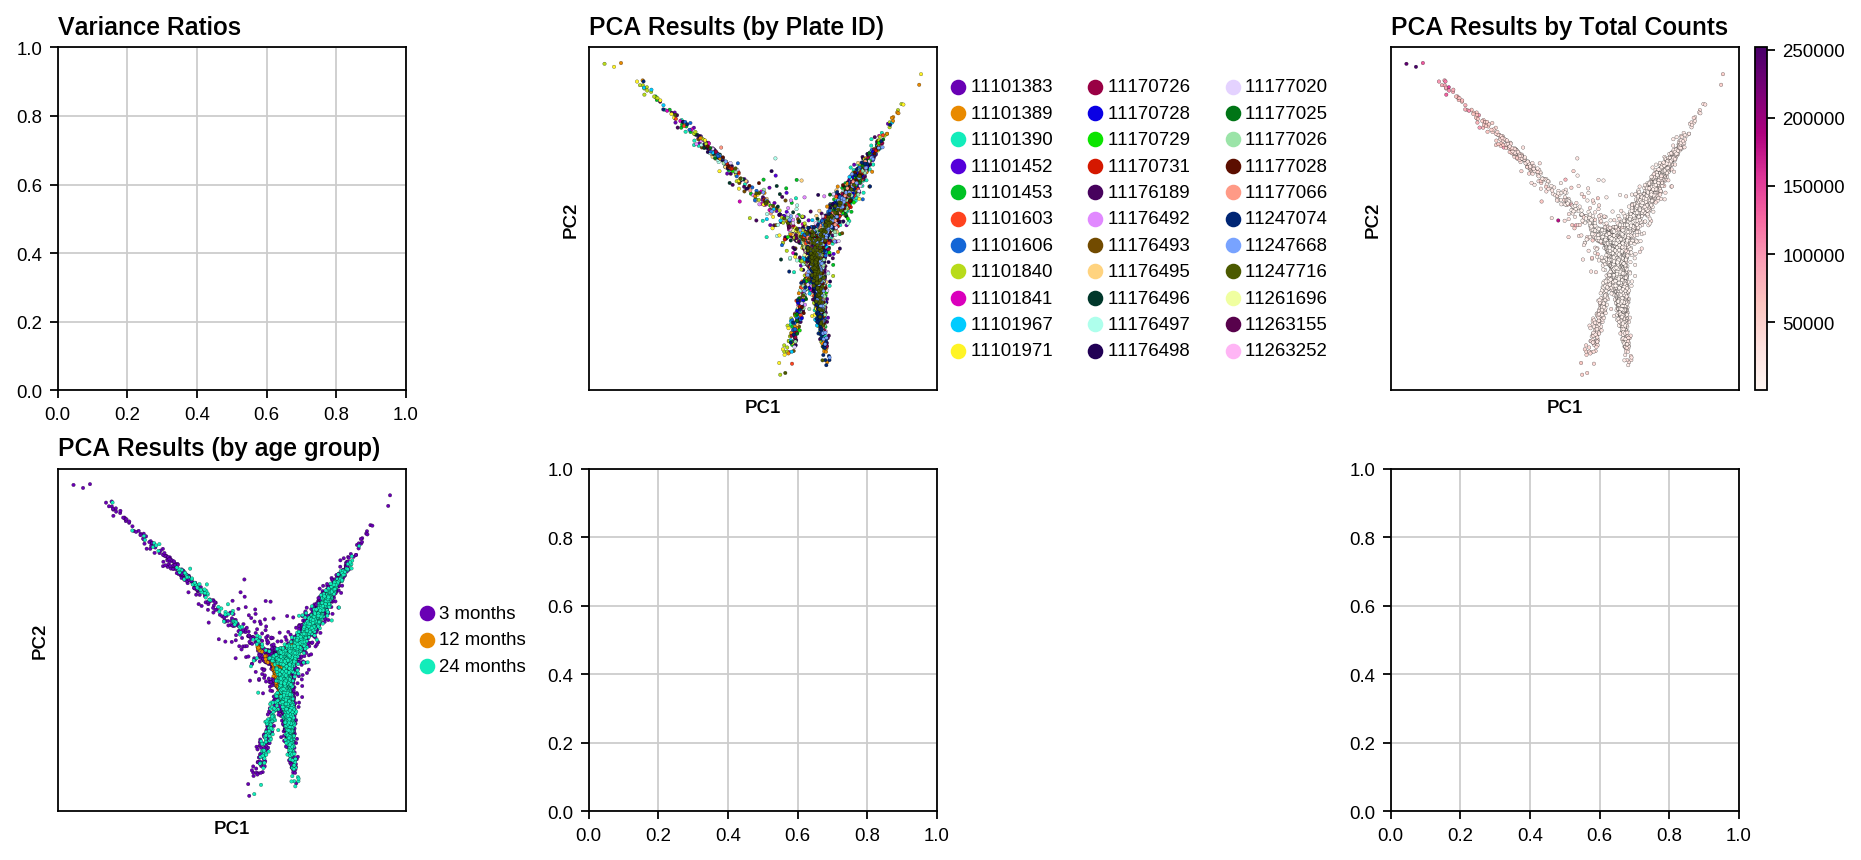

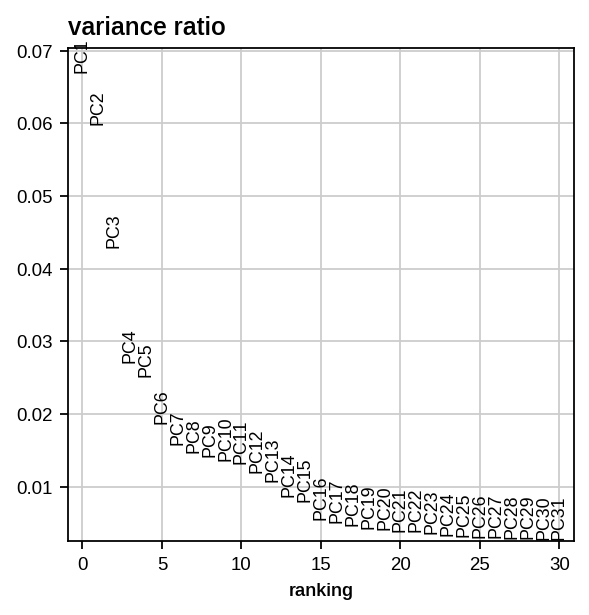

In [16]:
# Computing PCA with pearson residuals on the raw count matrix
adata.X = adata.layers["raw_counts"].copy()
sc.experimental.pp.normalize_pearson_residuals_pca(adata)

# We inspect the PCA results
fig, axes = plt.subplots(2, 3, figsize=(fig_width*3.5, fig_width*1.6), layout= "compressed")

sc.pl.pca_variance_ratio(adata, show= False)
axes[0, 0].set_title("Variance Ratios")

# PCA by plate
sc.pl.pca(adata, color= "plate",
          palette= my_cmap.colors,
          s= 10,
          edgecolor= "black",
          linewidth= 0.1,
          ax= axes[0, 1],
          sort_order= False,
          show= False)
axes[0, 1].set_title("PCA Results (by Plate ID)")

# PCA by total counts
sc.pl.pca(adata, color= "total_counts",
          s= 10,
          edgecolor= "black",
          linewidth= 0.1,
          ax= axes[0, 2],
          sort_order= False,
          show= False)
axes[0, 2].set_title("PCA Results by Total Counts")

# PCA by age group
sc.pl.pca(adata, color= "age",
          palette= my_cmap.colors,
          s= 10,
          edgecolor= "black",
          linewidth= 0.1,
          ax= axes[1, 0],
          sort_order= False,
          show= False)
axes[1, 0].set_title("PCA Results (by age group)")

fig.savefig(figures_folder + r"\PCA_Results_SGNplates.png")
plt.show()

### UMAP Embedding

We batch correct the data by calculating a batch-balances k-nearest neighbor (BBKNN) graph and calculate a UMAP projection.
The batch covariate is the plateID, so we correct for differences between each plate.

In [17]:
# BBKNN embedding
adata.X = adata.layers["pearson_normalized_counts"].copy()
bbknn.bbknn(adata, batch_key= "age", neighbors_within_batch= 3)

# UMAP Embedding
sc.tl.umap(adata, min_dist= 1.3, spread= 1.6)

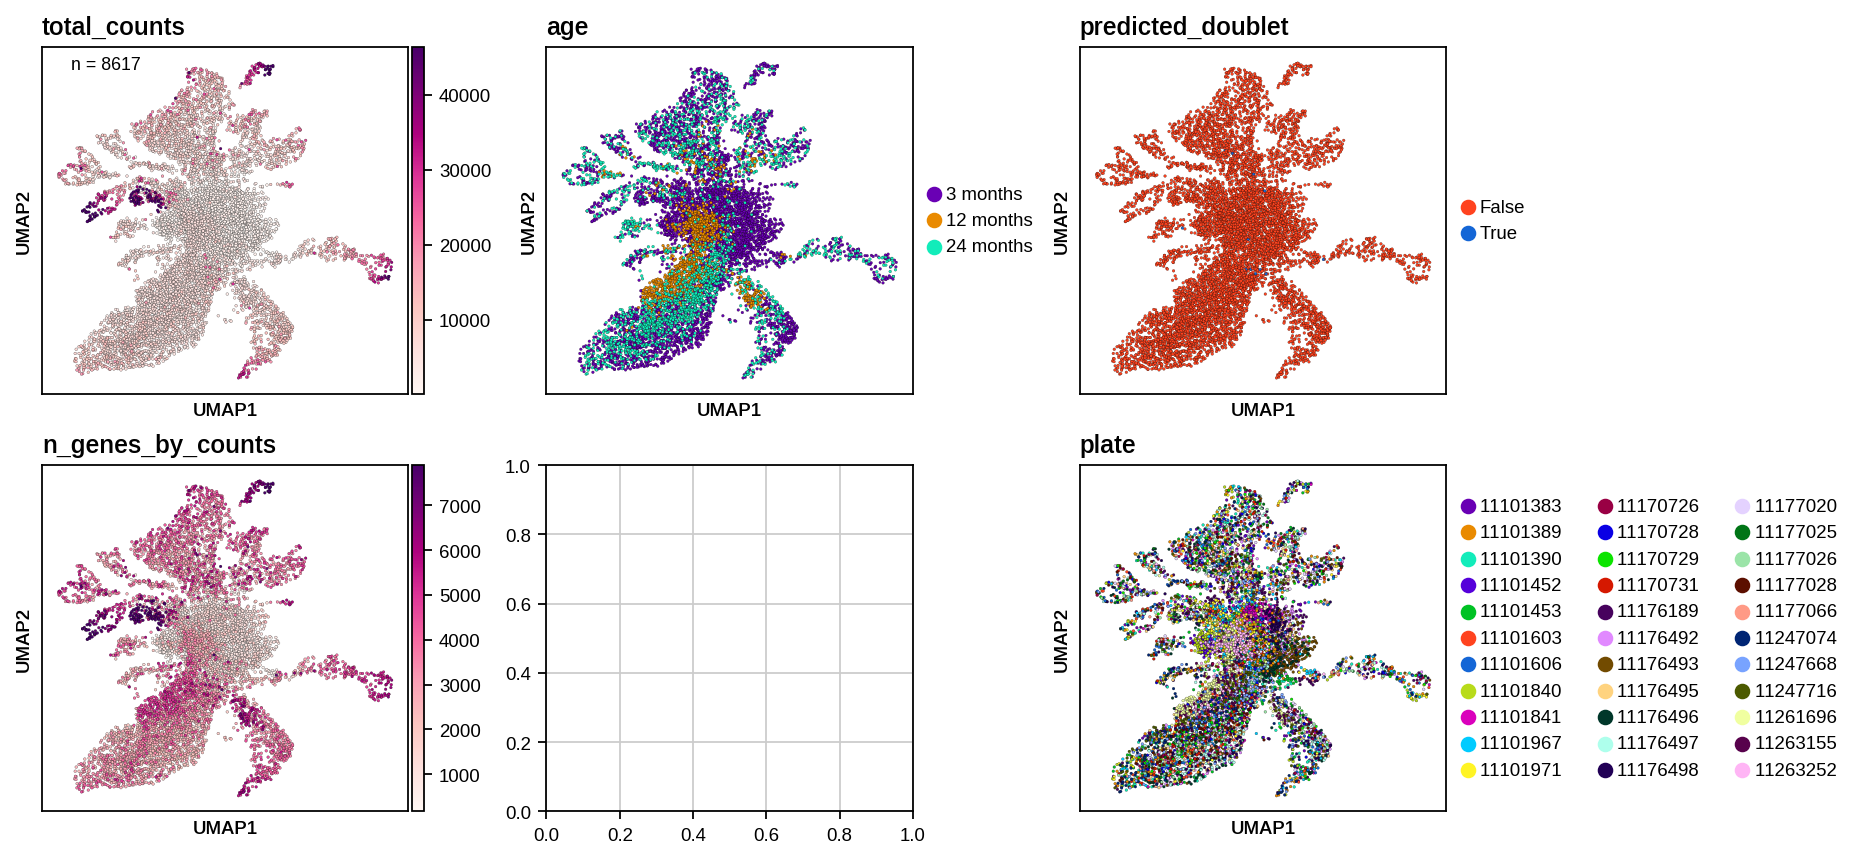

In [22]:
# Plotting before filtering
fig, axs = plt.subplots(2, 3, figsize= (fig_width*3.5, fig_width*1.6), layout= "compressed")

dot_size = 6
vmax = "p99"
sc.pl.umap(adata,
           color=["total_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 0],
           show= False)
axs[0, 0].text(-16,28, f"n = {adata.n_obs}", size= 8)

sc.pl.umap(adata,
           color=["n_genes_by_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 0],
           show= False)

sc.pl.umap(adata,
           color=["predicted_doublet"],
           palette= my_cmap.colors[5:],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 2],
           show= False)

sc.pl.umap(adata,
           color=["age"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 1],
           show= False)

sc.pl.umap(adata,
           color=["plate"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 2],
           show= False)

fig.savefig(figures_folder + r"\UMAP_Prefilter_SGNPlates.png")
plt.show()

### Filtering

We filter out cells and genes that we determined to be outliers as defined above.<br>
Exclusion criteria:
- total genes counts outside of 4 MADs in positive or negative direction
- less than 1000 genes expressed per nucleus (due to Smart-seq3xpress performance)
- single genes expressed in less than 3 cells in data set


In [23]:
# And this is also what we have to do with out custom "outlier" annotations
print(f"Number of nuclei before outliers: {adata.n_obs}")
adata = adata[(~adata.obs["outlier"])]
print(f"Number of nuclei after outliers: {adata.n_obs}\n")

print(f"Number of nuclei before count exclusion: {len(adata.obs)}")
sc.pp.filter_genes(adata, min_cells= 3, inplace= True)
print(f"Number of cells after count exclusion: {len(adata.obs)}")

Number of nuclei before outliers: 8617
Number of nuclei after outliers: 4221

Number of nuclei before count exclusion: 4221


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of cells after count exclusion: 4221


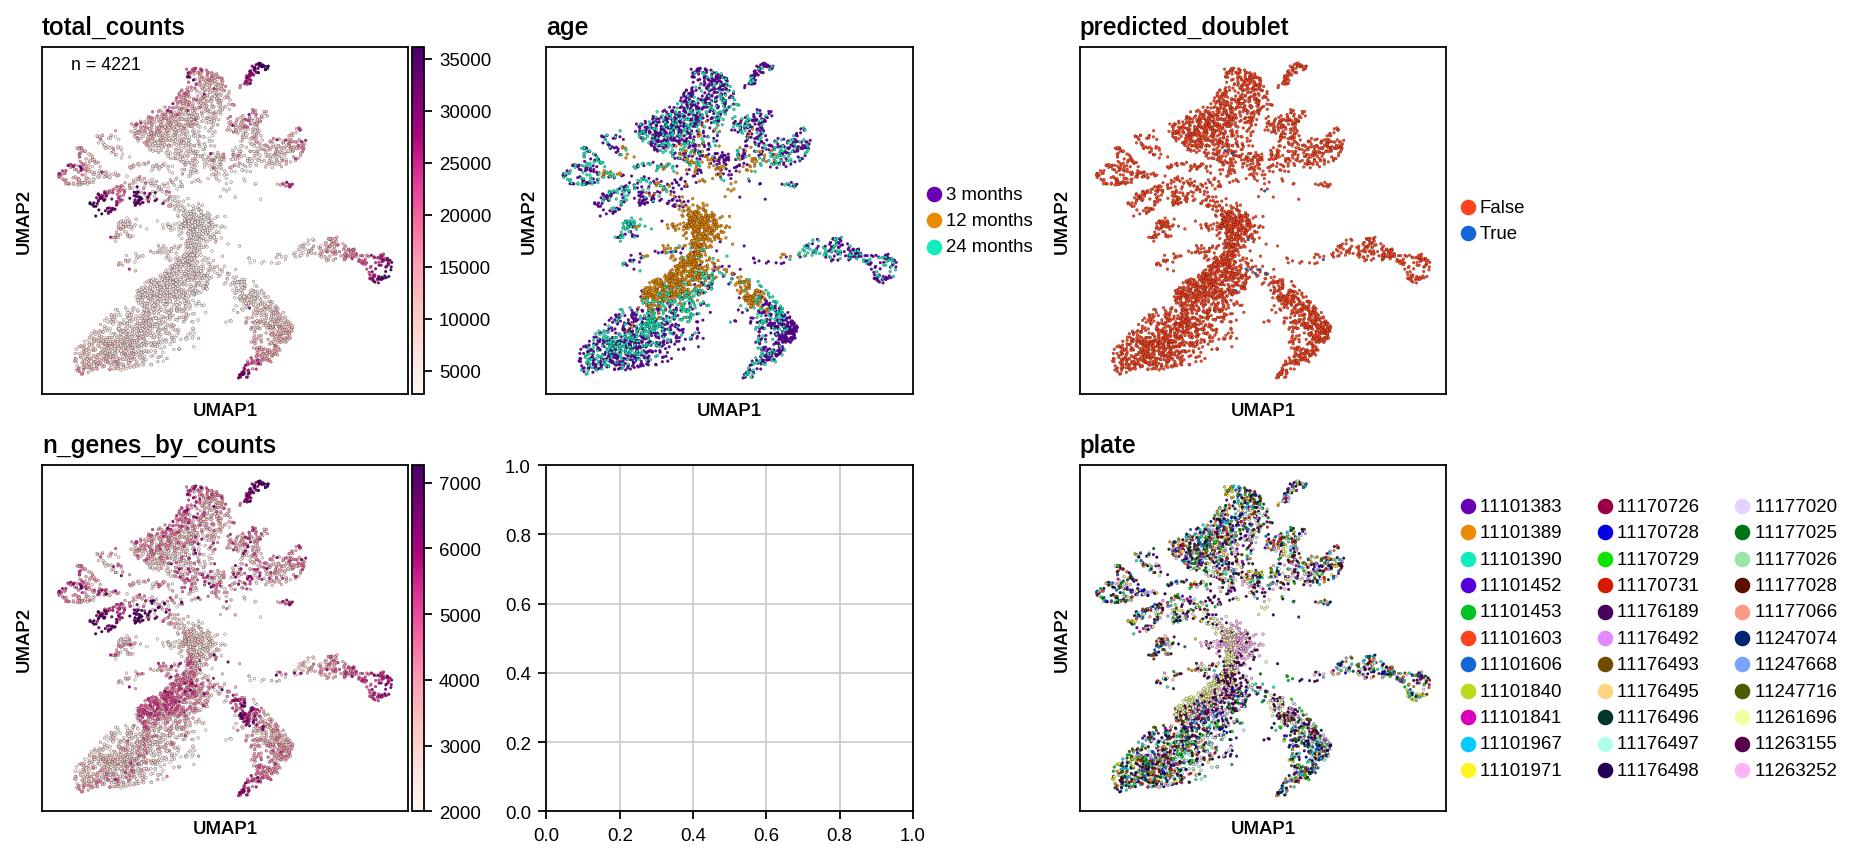

In [24]:
# Plotting before filtering
fig, axs = plt.subplots(2, 3, figsize= (fig_width*3.5, fig_width*1.6), layout= "compressed")

dot_size = 6
vmax = "p99"
sc.pl.umap(adata,
           color=["total_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 0],
           show= False)
axs[0, 0].text(-16,28, f"n = {adata.n_obs}", size= 8)

sc.pl.umap(adata,
           color=["n_genes_by_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 0],
           show= False)

sc.pl.umap(adata,
           color=["predicted_doublet"],
           palette= my_cmap.colors[5:],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 2],
           show= False)

sc.pl.umap(adata,
           color=["age"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[0, 1],
           show= False)

sc.pl.umap(adata,
           color=["plate"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.1,
           ax= axs[1, 2],
           show= False)

fig.savefig(figures_folder + r"\UMAP_Postfilter_SGNPlates.png")
plt.show()

### Clustering and Annotating

We cluster using the Leiden algorithm.

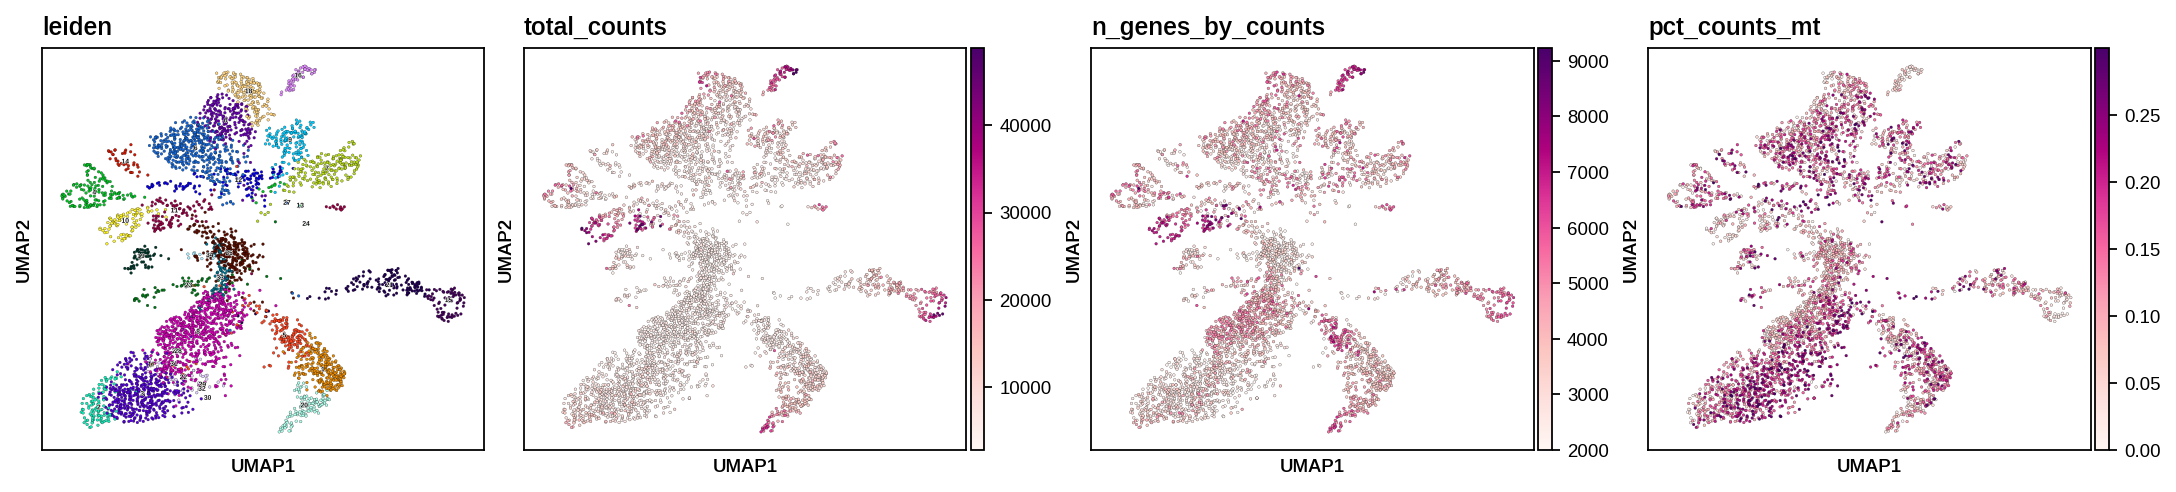

In [25]:
adata.X = adata.layers["pearson_normalized_counts"].copy() # The leiden() function requires normalized counts

# Clustering ...
sc.tl.leiden(adata,
             flavor= "igraph",
             n_iterations= -1, # iterate until the best clusters have been found
             resolution= 1, # higher number means finer clusters
             key_added= "leiden")

# Plotting the clusters
fig, ax = plt.subplots(1,4, figsize= (fig_width*4.1, fig_width*0.9), layout= "compressed")

for i, metric in enumerate(["leiden", "total_counts", "n_genes_by_counts", "pct_counts_mt"]):
    sc.pl.umap(adata, color= metric,
               palette= my_cmap.colors,
               size= 6,
               edgecolor= "black",
               linewidth= 0.1,
               legend_loc= "on data",
               legend_fontsize = 3,
               legend_fontoutline = 0.4,
               ax= ax[i],
               show= False)

fig.savefig(figures_folder + r"\Leiden_Clustering_SGNplates.png")
plt.show()

#### Loading Marker Genes

A list of literature markers of different cochlear cell types.

In [26]:
# Marker Genes
# Loading previously saved markers
with open("cochlea_markers.json", "r") as file:
    markers_SGN = json.load(file)

# Checking which marker genes are present in the dataset
markers_in_data = {}
for ct, markers in markers_SGN.items():
    if np.intersect1d(markers, adata.var_names).size > 0:
        markers_in_data[ct] = list(np.intersect1d(markers, adata.var_names))

# printing the final list of available marker genes
print("Marker genes present in data:\n")
for item in markers_in_data.items():
    print(f"{item[0]}: {item[1]}")

Marker genes present in data:

Hair Cells: ['Cib2', 'Myo6', 'Myo7a']
Inner Hair Cells: ['Otof', 'Slc17a8']
Outer Hair Cells: ['Ikzf2', 'Kcnq4', 'Slc26a5', 'Strc']
Deiter Cells: ['Crhr1', 'Fabp3', 'Fgfr3', 'Plxnb2']
Inner Pillar Cells: ['Bmp6', 'Fgfr3', 'Lgr5']
Outer Pillar Cells: ['Cd44', 'Fgfr3']
Inner Phalangeal Cells: ['Cpa6', 'Far1', 'Gpc2', 'Otog', 'Slc1a3']
Claudius Cells: ['Aqp4', 'Car12', 'Cobl', 'Otoa', 'Rspo2']
Hensen Cells: ['Cd44', 'Cobl', 'Dpysl4', 'Lockd', 'Zbtb20']
Boettcher Cells: ['Car12', 'Rspo2']
Inner Sulcus Cells: ['Aqp4', 'Bmp4']
Interdental Cells: ['Otoa']
Macrophages: ['C1qb', 'Csf1r', 'Fcgr3', 'Lgmn', 'Mrc1', 'Ptprc']
Endothelial Cells: ['Cdh5', 'Esam', 'Flt1', 'Tie1']
Pericytes: ['Cspg4', 'Pdgfrb', 'Rgs5']
Intermediate Cells: ['Col5a3', 'Kcnj10']
Basal Cells: ['Atp6v0a4', 'Cldn11']
Spindle Cells: ['Anxa1', 'Dpp10']
Root Cells: ['Lgr5']
Reissner Cells: ['Frem2', 'Lmx1a', 'Slc26a7']
Tympanic Border Cells: ['Emcn', 'Emilin2']
Osteoblast: ['Dio2', 'Dlx5', 'Runx2',

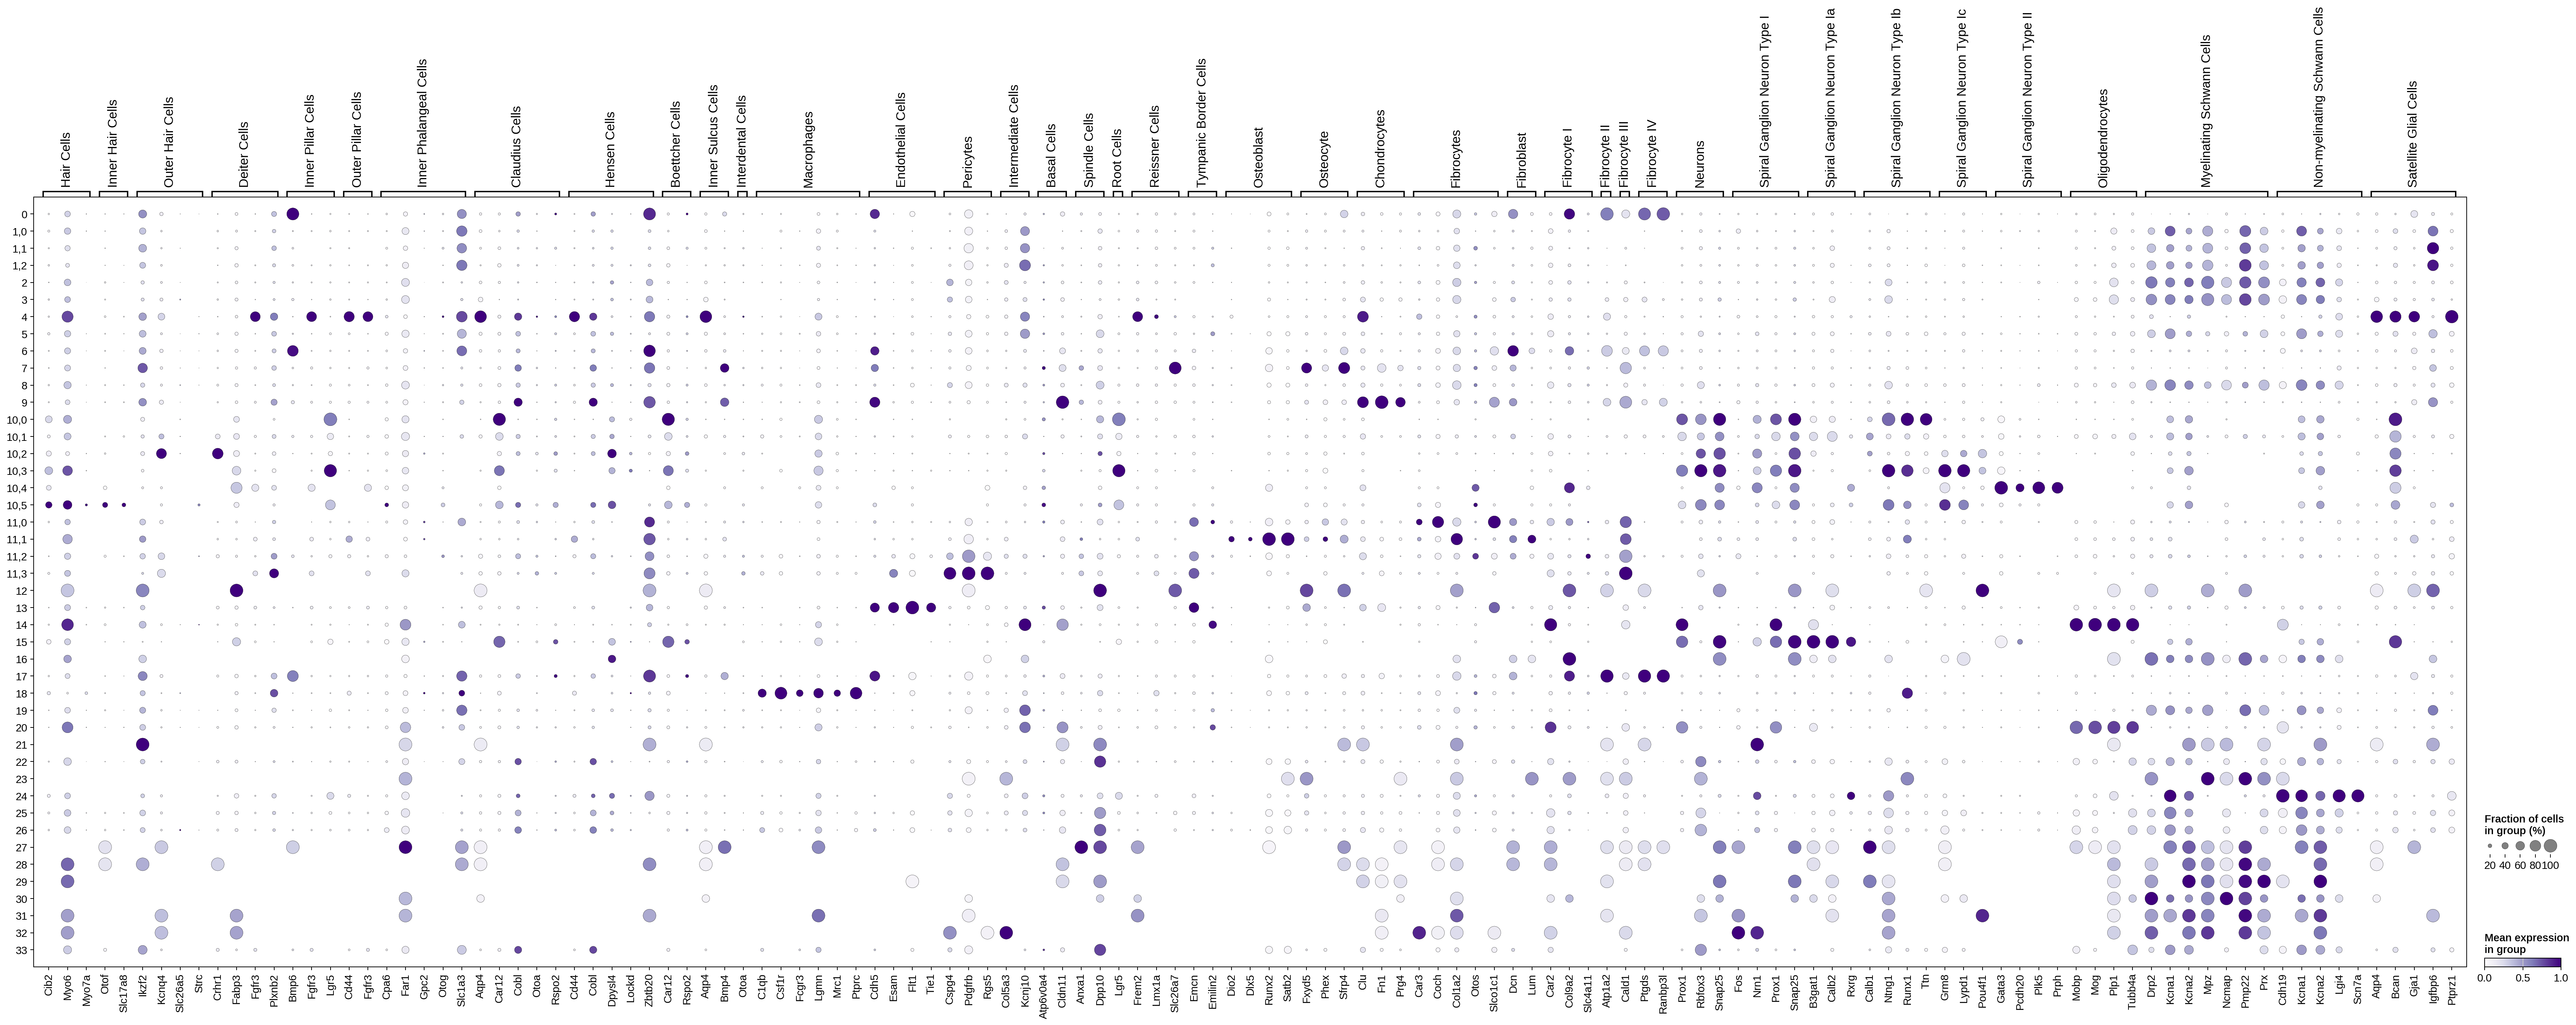

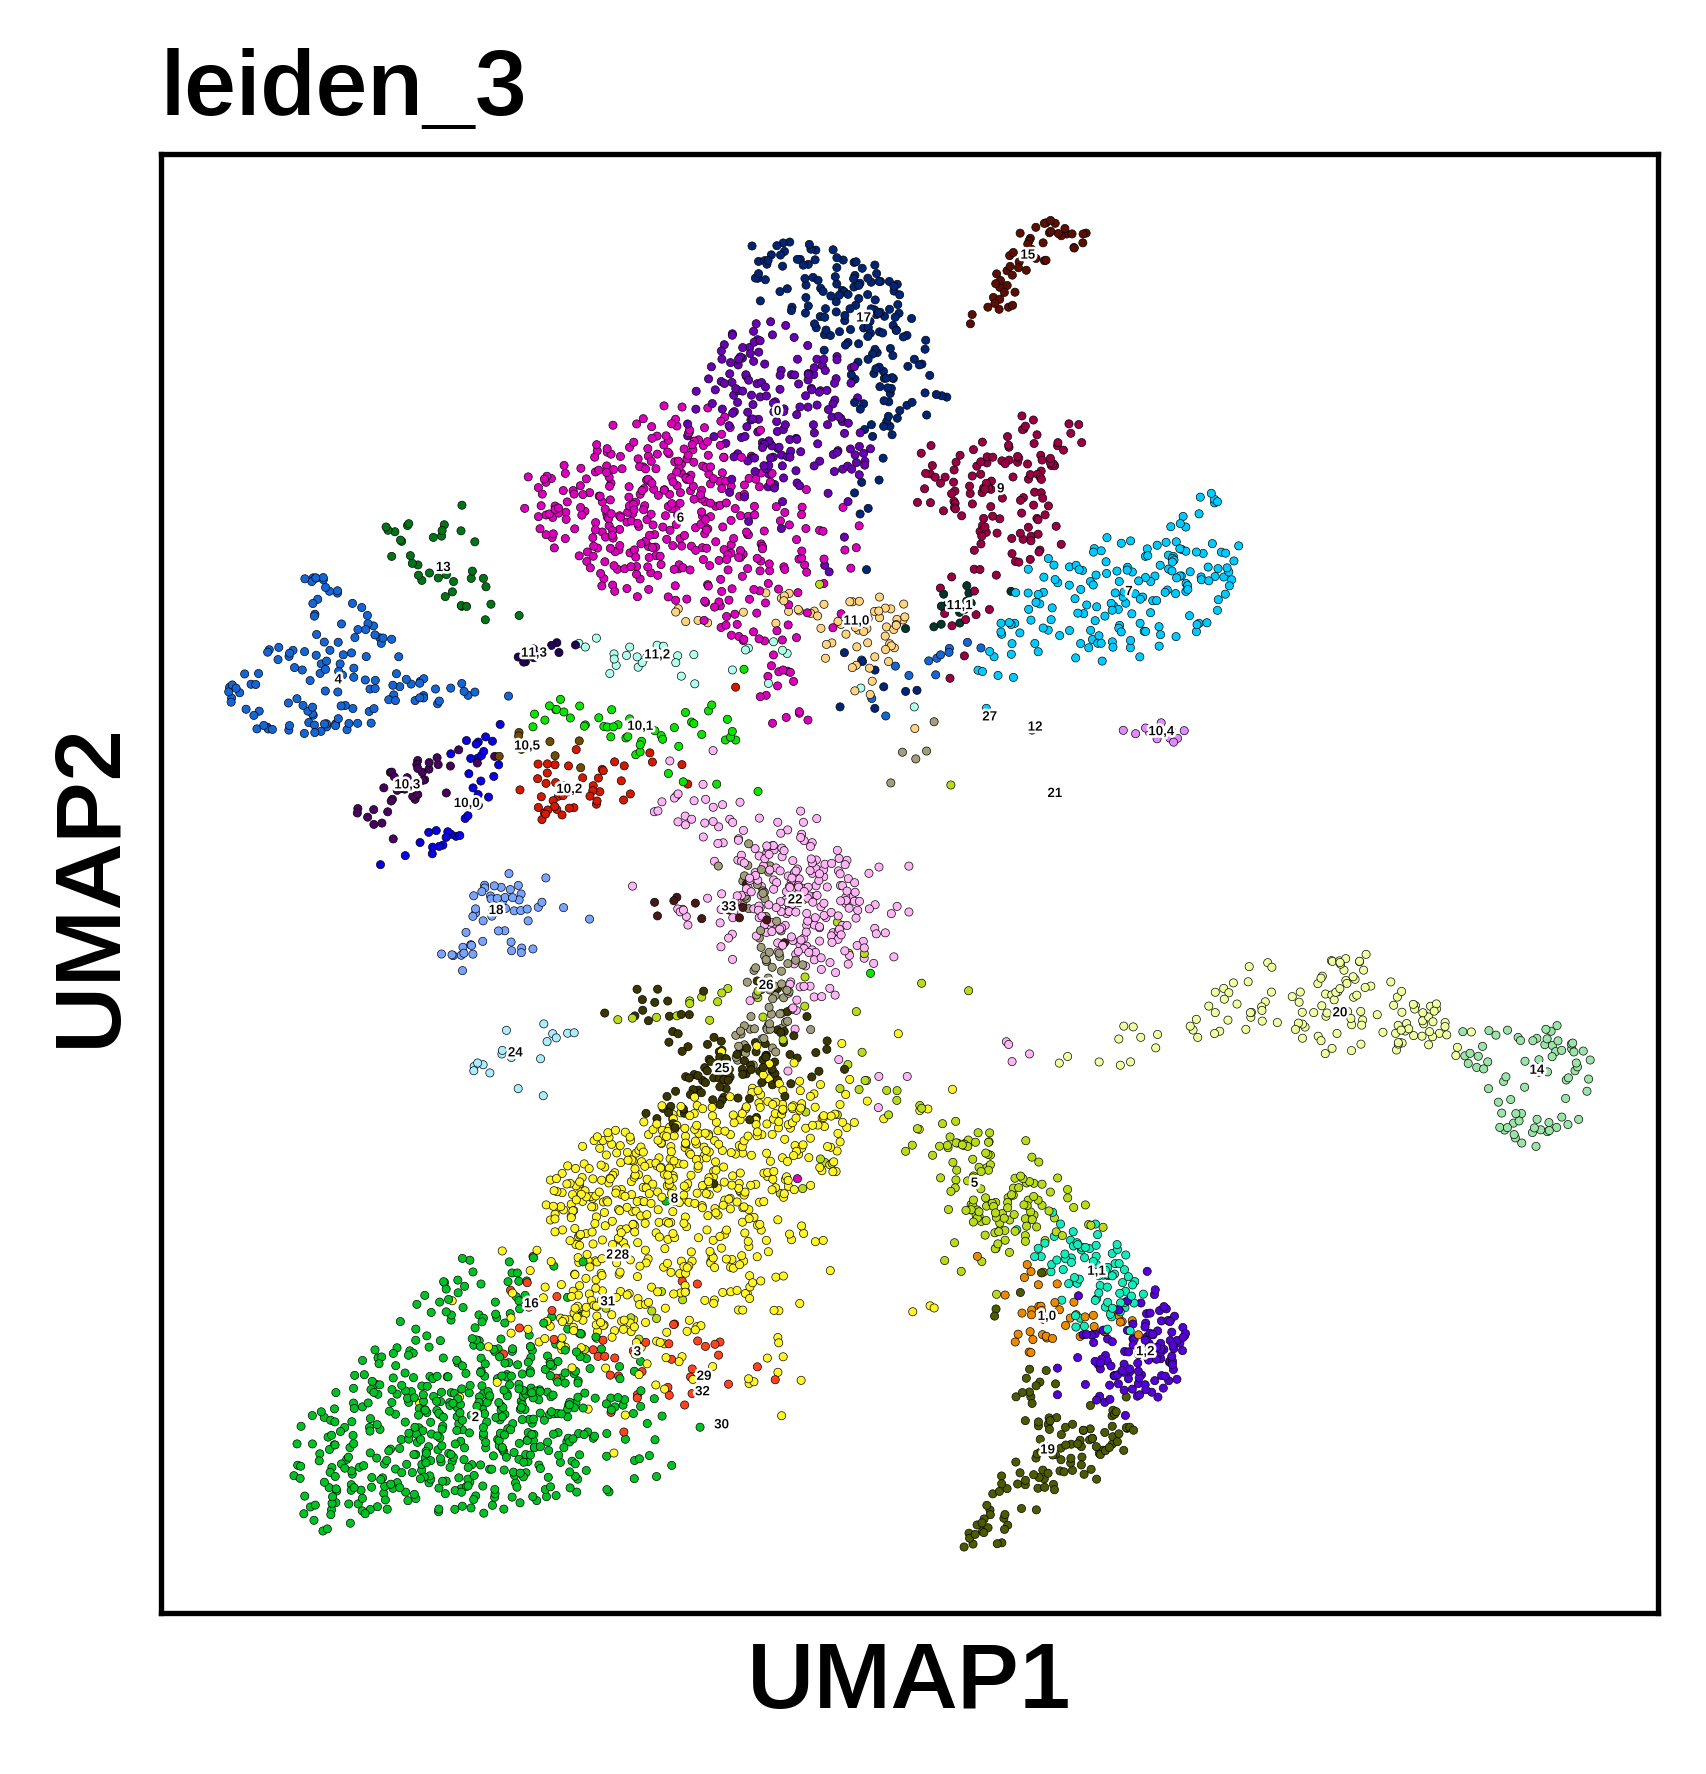

In [28]:
# Next, we check the expression patterns of the marker genes in our clustering
sc.tl.leiden(adata,
             flavor= "igraph",
             n_iterations= -1,
             resolution= 0.8,
             key_added= "leiden_0")

# After initial inspection, defining clusters that need sub-clustering
need_subclustering = {"1": 0.5,
                      "10": 0.5,
                      "11": 0.2}

# Successive sub-clustering of clusters that are too coarse to tell cell types apart
i = 1
for cluster, res in need_subclustering.items():
    sc.tl.leiden(adata, flavor= "igraph", n_iterations= -1, key_added= f"leiden_{i}",
                 resolution= res,
                 restrict_to= (f"leiden_{i-1}", [cluster]))
    i += 1

# Dotplot featuring all marker genes and all the clusters to manually determine cell identities in clusters
# THIS IS WHERE THE ACTUAL CLUSTER ANNOTATION CALLING HAPPENS
sc.pl.dotplot(adata,
              markers_in_data,
              groupby=f"leiden_{len(need_subclustering)}",
              standard_scale= "var",
              cmap= "Purples", # I like purple
              save= "Marker_Genes_SGNAtlas.png")

sc.set_figure_params(dpi= 240)
sc.pl.umap(adata,
           color=[f"leiden_{len(need_subclustering)}"],
           legend_loc="on data",
           legend_fontsize= 2,
           legend_fontoutline= 0.8,
           size= 6,
           palette= my_cmap.colors,
           edgecolor= "black",
           linewidth= 0.1)
sc.set_figure_params(dpi= 90)

In [ ]:
# Checking expression of marker genes across the whole dataset
sc.pl.umap(adata, color= "Pou4f1",
           edgecolor= "black",
           linewidth= 0.1)

#### Making Annotations

Identifying cell types for each cluster plotted in the dotplot above.

In [ ]:
# Committing Annotations
annotations = {"0": "Myelinating Schwann Cells",
               "1,0": "Fibrocytes I",
               "1,1": "Fibrocytes I",
               "1,2": "Fibrocytes II",
               "1,3": "Fibrocytes IV",
               "1,4": "Unclear",
               "1,5": "Unclear",
               "2": "Satellite Glial Cells 1",
               "3": "Myelinating Schwann Cells",
               "4": "Myelinating Schwann Cells",
               "5": "Endothelial Cells",
               "6": "Satellite Glial Cells 2",
               "7": "Fibroblasts",
               "8": "Osteocytes",
               "9": "Chondrocytes",
               "10,0": "Spiral Ganglion Neuron Type Ib",
               "10,2": "Spiral Ganglion Neuron Type Ib",
               "10,1": "Spiral Ganglion Neuron Type Ic",
               "10,3": "Spiral Ganglion Neuron Type Ic",
               "11,0": "Spiral Ganglion Neuron Type II",
               "11,1": "Unclear",
               "11,2": "Unclear",
               "11,3": "Unclear",
               "12": "Fibrocyte III",
               "13": "Spiral Ganglion Neuron Type II",
               "14": "Oligodendrocytes",
               "15": "Spiral Ganglion Neuron Type Ia",
               "16": "Satellite Glial Cells 1",
               "17": "Myelinating Schwann Cells",
               "18": "Macrophages",
               "19": "Non-myelinating Schwann Cells",
               "20": "Unclear",
               "21": "Unclear",
               "22": "Myelinating Schwann Cells",
               "23": "Myelinating Schwann Cells",
               "24": "Myelinating Schwann Cells",
               "25": "Myelinating Schwann Cells",
               "26": "Myelinating Schwann Cells",
               "27": "Myelinating Schwann Cells",
               "28": "Myelinating Schwann Cells"}

# Refactoring the cluster identity and saving it to a new annotation as cell types
adata.obs["manual_celltypes"] = adata.obs[f"leiden_{len(need_subclustering)}"].map(annotations)

# Saving the annotated dataset
adata.write_h5ad(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\CBA_SGN_Atlas_Annotated.h5ad")

In [ ]:
# Plotting Cell Type Annotations
fig, ax = plt.subplots(2,1, figsize=(fig_width*2.1, fig_width*1.8), layout= "compressed")

sc.pl.umap(adata,
           color=["manual_celltypes"],
           edgecolor= "black",
           linewidth= 0.15,
           size= 10,
           palette= my_cmap.colors,
           legend_fontsize= 6*scale,
           ax = ax[0],
           show= False)
ax[0].set_title("Low Quality Aging Atlas SGN", fontsize= 10)

sc.pl.umap(adata,
           color=["age"],
           edgecolor= "black",
           linewidth= 0.15,
           size= 10,
           palette= [my_cmap.colors[4],
                     my_cmap.colors[6],
                     my_cmap.colors[5]],
            legend_loc= "upper right",
           legend_fontsize= 6*scale,
           ax = ax[1],
           show= False)
ax[1].set_title("Age Difference", fontsize= 10)
ax[1].legend(frameon= False)

fig.savefig(figures_folder + r"\SGN_Atlas_Annotated.png")
plt.show()

### Gene Expression Analysis

We isolate cell types of interest and verify their marker expressions. Further, I am doing a rudimentary **Differential Gene Expression Analysis** using the `sc.tl.rank_genes_groups()` method that determines differentially expressed genes between defined groups and ranks by giving each gene a differential expression score.

In [25]:
# Loading previously annotated data
adata = sc.read_h5ad(r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Data\CBA_SGN_Atlas_Annotated.h5ad")

# And reducing the dataset to only SGNs
adata_SGNonly = adata[adata.obs["manual_celltypes"].isin(["Spiral Ganglion Neuron Type II",
                                                          "Spiral Ganglion Neuron Type Ia",
                                                          "Spiral Ganglion Neuron Type Ib",
                                                          "Spiral Ganglion Neuron Type Ic"])].copy()

In [ ]:
markers_to_plot = ["Gata3", # Type II
                   "Calb2",
                   "Ttn",
                   "Lypd1"]   # Type Ib

fig, axes = plt.subplots(2,5, figsize=(fig_width*3.4, fig_width*1), layout= "compressed")

dot_size = 30
line_width = 0.3
vmax = "p99"
sc.pl.umap(adata_SGNonly,
           color=["manual_celltypes"],
           edgecolor= "black",
           linewidth= line_width,
           size= dot_size,
           palette= my_cmap.colors[14:18],
           ax= axes[0, 0],
           show= False,
           vmax= vmax,
           title= "")

sc.pl.umap(adata_SGNonly[adata_SGNonly.obs["manual_celltypes"].isin(["Spiral Ganglion Neuron Type Ib", "Spiral Ganglion Neuron Type Ic"])],
           color=["age"],
           edgecolor= "black",
           linewidth= line_width,
           size= dot_size*2.3,
           palette= my_cmap.colors[4:],
           ax= axes[1, 0],
           show= False,
           vmax= vmax,
           title= "Age Difference")

for i, mark in enumerate(markers_to_plot):
    sc.pl.umap(adata_SGNonly,
               color= mark,
               size= dot_size,
               vmax= vmax,
               legend_loc= "none",
               edgecolor= "black",
               linewidth= line_width,
               ax= axes[int(i/2), i+1],
               title= mark,
               show= False)
    axes[int(i/2), i+1].set_ylabel("Normalized Expression")

fig.savefig(figures_folder + r"\Marker_Gene_Expressions_Ages_SGNplates.png")
plt.show()

c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


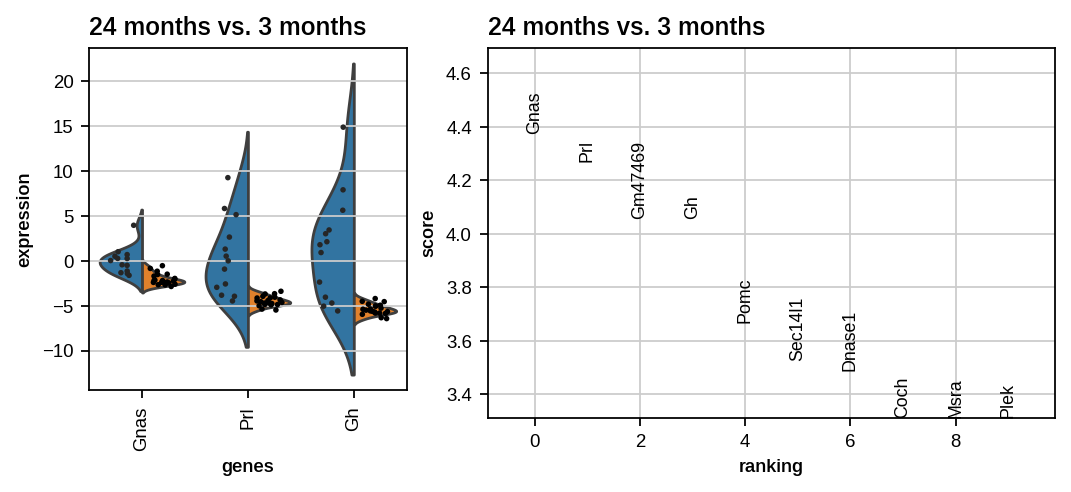

In [26]:
adata_DEG = adata_SGNonly[adata_SGNonly.obs["manual_celltypes"].str.contains("Type Ib")].copy()

sc.tl.rank_genes_groups(adata_DEG, "age",
                        group= ["24 months"],
                        reference= "3 months",
                        method='wilcoxon',
                        n_genes= 10)

# Plotting
fig, axs = plt.subplots(1,2, figsize= (fig_width*2, fig_width*0.9), layout= "compressed", width_ratios= (1,2))

sc.pl.rank_genes_groups(adata_DEG, n_genes=10, ax= axs[1], show= False,
                        title= "DEGs 24 months vs. 3 months")
axs[1].set_axis_off()
axs[1].set_ylim(2,10)

sc.pl.rank_genes_groups_violin(adata_DEG, groups= ["24 months"],
                               gene_names= ["Gnas", "Prl", "Gh"],
                               ax= axs[0],
                               size= 2.5,
                               jitter= 0.25)
axs[0].set_title("SGN Type Ib")
axs[0].set_zorder(3)

fig.savefig(figures_folder + r"\DEGs_TypeIb.png")
plt.show()

Lypd1 Ranksum Test:
 RanksumsResult(statistic=1.1686757528317417, pvalue=0.2425342946671959)
Calb2 Ranksum Test:
 RanksumsResult(statistic=1.2161828972557964, pvalue=0.22391525729211859)


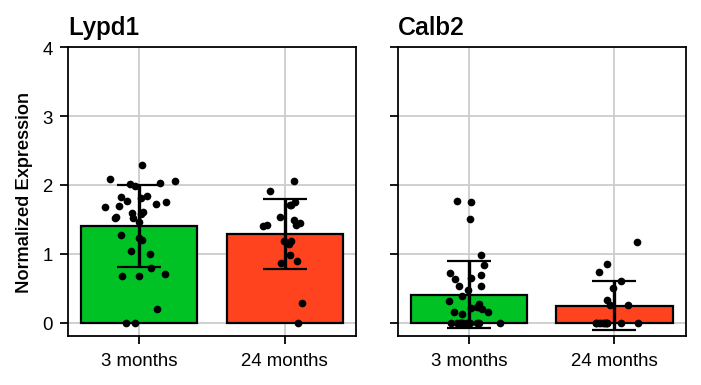

In [33]:
data = dict()
adata = sc.read_h5ad(r"C:\Users\jkorn\Documents\Coding\Python\Master Thesis Data\Data\CBA_SGN_Atlas_Annotated.h5ad")
adata.X = adata.layers["log1p_normalized_counts"].copy()
adata_SGNonly = adata[adata.obs["manual_celltypes"].isin(["Spiral Ganglion Neuron Type Ic"])].copy()

data["3 months"] = {"Lypd1": np.array(adata_SGNonly[adata_SGNonly.obs["age"] == "3 months", "Lypd1"].to_df()["Lypd1"].tolist()),
                    "Calb2": np.array(adata_SGNonly[adata_SGNonly.obs["age"] == "3 months", "Calb2"].to_df()["Calb2"].tolist())}
data["24 months"] = {"Lypd1": np.array(adata_SGNonly[adata_SGNonly.obs["age"] == "24 months", "Lypd1"].to_df()["Lypd1"].tolist()),
                     "Calb2": np.array(adata_SGNonly[adata_SGNonly.obs["age"] == "24 months", "Calb2"].to_df()["Calb2"].tolist())}

fig, axs = plt.subplots(1,2, figsize= (fig_width*1.4, fig_width*0.8), layout= "tight", sharey= True)

for i, marker in enumerate(["Lypd1", "Calb2"]):
    for j, age in enumerate(data.keys()):
        axs[i].bar([age],
                np.mean(data[age][marker]),
                color= my_cmap.colors[j+4],
                    edgecolor= "black",
                    linewidth = 1,
                    yerr= np.std(data[age][marker]),
                    error_kw= {"ecolor": "black",
                                "linewidth": 1.5,
                                "capsize": 10},
                    zorder= 2)
        axs[i].scatter(np.random.normal(j, 0.1, len(data[age][marker])).tolist(),
           data[age][marker],
           color = "black",
           s = 6,
           zorder= 3)
        axs[i].set_title(marker)
    else:
        print(f"{marker} Ranksum Test:\n", st.ranksums(data["3 months"][marker], data["24 months"][marker]))

axs[0].set_ylabel("Normalized Expression")
axs[0].set_ylim(-0.2, 4)

fig.savefig(figures_folder + r"\Expression_Markergenes_Stains_TypeIc.png", dpi= 600)
plt.show()

In [ ]:
test= np.array(adata_SGNonly[adata_SGNonly.obs["age"] == "3 months", "Lypd1"].X)
test = test + -1*test.min()
test.min()